# 2023 년 10월 7일 2일차 코드 실습

## 🎯 실습 목표
1. CNN 모델의 성능을 올릴 수 있는 다양한 technique 소개
    - Data Augmentation
    - Test Time Augmentation
    - Ensemble
    - Pseudo Labeling
    - Label Smoothing

2. 각 technique 의 구현 방법 실습

3. CNN 모델을 분석하는 방법
    - t-SNE embedding & visualization
    - Error analysis


## 실습 데이터셋
- [CIFAR-10](dddd)
    - CIFAR-10 은 컴퓨터비전과 머신러닝 분야에서 매우 널리 쓰이는 이미지 데이터셋입니다.
    - 총 class 는 10개 이고 다음과 같습니다.
        - Airplane
        - Automobile (car)
        - Bird
        - Cat
        - Deer
        - Dog
        - Frog
        - Horse
        - Ship
        - Truck
    - 이미지 크기는 (32, 32) 입니다.
    - torchvision package 에서 다운 받을 수 있으므로 따로 다운로드 진행 안해도 됩니다.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os, random
import numpy as np

seed=2023-10-7
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 1. 탐색적 데이터 분석
- 간단히 이미지 데이터를 시각화하여 어떤 사진들이 있는지 알아봅니다

100%|██████████| 170498071/170498071 [00:45<00:00, 3733706.21it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


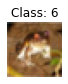

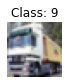

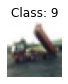

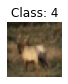

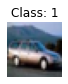

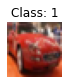

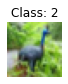

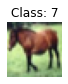

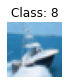

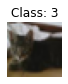

In [3]:
import matplotlib.pyplot as plt

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, # 이 인자를 True 로 해주면 알아서 다운이 받아짐. cache 폴더에 저장되므로, 세션을 다시 시작할 때마다 다운을 받아줘야함.
                                             transform=None,
                                             download=True)

def visualize_img_tensor(img, class_name):
    fig, ax = plt.subplots(1,1, figsize=(1,1))
    # pdb.set_trace()
    ax.imshow(img.permute(1,2,0))

    plt.title(f"Class: {class_name}", fontsize=12)
    plt.axis("off")

    plt.show()

def visualize_img(img, class_name):
    fig, ax = plt.subplots(1,1, figsize=(1,1))

    ax.imshow(img)
    plt.title(f"Class: {class_name}", fontsize=12)
    plt.axis("off")

    plt.show()


for i, (img, cls) in enumerate(train_dataset):
    visualize_img(img, cls)
    if i ==9:
        break

# 2. Image Augmentation

- Machine Learning 모델에서 중요한 목표는 새로운 데이터에 더 잘 일반화하는 것입니다. (improving the generalization ability)
    - 즉, 학습 데이터에 과적합 (overfitting) 되는 것을 피하는 것입니다.
- 이번 섹션에서는 다양한 regularization 방법들 중, 이미지 분야에서 매우 효과적이라고 알려져 있는 data augmentation (데이터 증강) 기법을 구현하는 방법을 실습합니다.

- 데이터 증강이 왜 필요할까요?
    - 데이터 수집은 노동 집약적이고 돈이 많이 듭니다. image 의 경우 web 에서 스크랩핑하여 구할 수 있지만, 이에 대응되는 class label 은 crowd sourcing 등을 이용하여 수행해야합니다.
    - 이 과정은 돈이 상당히 많이 들기 때문에 일반적으로 많은 양의 학습 데이터를 구하기가 어렵습니다.
    - 단적인 예로, 널리 알려진 imagenet 은 총 1400만장으로 이루어져 있습니다.
    - 장당 10원이라고 하면... 1억이 넘어가는 돈입니다! 이런 상황에서 데이터 증강은 큰 힘이 될 수 있습니다.

<img src='https://albumentations.ai/docs/images/introduction/image_augmentation/augmentation.jpg' width="600" height="auto">

- 위 사진처럼 데이터 증강은 학습 데이터의 양을 늘려줄 수 있습니다. 일반적으로 학습 데이터가 충분히 많으면 과적합이 일어날 가능성이 낮아집니다.
    - 또한, 단순히 동일한 이미지를 resampling 하여 늘려주는 것이 아니라, 이미지 본래의 의미 (앵무새) 는 유지하면서 스타일 (e.g., 방향, 확대, 색깔) 만 바꿔주는 것이기 때문에, 다양한 상황에서 촬영된 이미지들에 대해 강건하게 (robust) 예측할 수 있습니다.




- 이미지 데이터 증강을 할 수 있는 다양한 패키지들이 있는데 오늘은 그 중 `torchvision` 패키지를 이용합니다.


## 2-1. 기본적인 데이터 증강 방식 소개
- 지금부터 `torchvision` 패키지로 가능한 다양한 데이터 증강 방법들을 소개드리도록 하겠습니다.
- 이것들을 다 외우실 필요는 없고, 아 이런 것들도 가능하구나 라는 것을 인지해주시고, 나중에 이 자료를 참고해서 적용해보시면 좋을 것 같습니다.


### 무작위 상하 반전 데이터 증강

- 상하를 반전시키는 데이터 증강 방법.
- `p=0.5` 인자를 이용해서 데이터 증강이 일어날 확률을 지정해줍니다.

Files already downloaded and verified


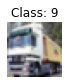

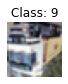

In [4]:
augmentation = transforms.RandomVerticalFlip(p=1)

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=True)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])


# 뒤집어 져있는 상태도 학습하게 해준다.

### 무작위 좌우 반전 데이터 증강

- 좌우를 반전시키는 데이터 증강 방법.
- `p=0.5` 인자를 이용해서 데이터 증강이 일어날 확률을 지정해줍니다.

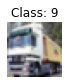

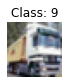

In [5]:
# 무작위 좌우반전 데이터 증강
augmentation = transforms.RandomHorizontalFlip(p=1) # argument p 의 값을 조절해서 데이터 증강이 일어날 확률을 정해줍니다.

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])

### 무작위 crop 데이터 증강

- (width, height)의 잘라낼 크기를 설정하면, 그 크기만큼 랜덤으로 잘라냅니다.
    - 예를 들어, (32,32) 크기의 이미지를 (10,10) 크기의 이미지로 crop 하라고 하면 결과물로 (10,10) 이미지가 나오게 됩니다.
- 주의: crop의 크기가 이미지의 크기보다 크면 에러가 납니다.

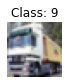

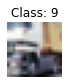

In [8]:
augmentation = transforms.RandomCrop((20, 20))

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])

### 무작위 crop 인데 resize 까지!
- 위 예시와 같이 (32,32) 이미지를 (10,10) 로 crop 하게 되면 결과물이 (10,10) 으로 나오게 되는데
- CNN 모델의 구조상, 모든 입력 이미지가 동일한 크기를 가져야합니다.
- 그래서 crop 을 하면 필수적으로 input 크기를 crop 전 크기로 바꾸어 줘야합니다.
- `RandomResizedCrop()` 은 무작위 크기로 crop 한 후에, 지정한 size 로 바꾸어줍니다.

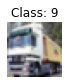

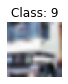

In [10]:
augmentation = transforms.RandomResizedCrop((32,32))

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])


# 밑에 픽셀은 더 러프하다.

### 무작위 회전 데이터 증강

- 주어진 각도에 따라 무작위로 회전시킵니다. 함수의 인자로 각도를 지정할 수 있습니다.
    - 예를 들어, 각도를 150 으로 지정하면 -150, +150 사이의 값을 무작위로 골라 회전시킵니다.



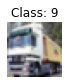

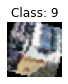

In [7]:
augmentation = transforms.RandomRotation(150) # 숫자는 각도에 대한 인자

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])

### 무작위 선택 데이터 증강
- 좀 더 랜덤성을 주고 싶을 때 사용할 수 있는 옵션입니다.
- 데이터 증강의 종류들을 지정해 놓으면, 무작위로 선택되어 데이터 증강이 진행됩니다.
- 모델 학습 시, 한가지의 augmentation 만 지정하게 되면 다양성이 부족해질 수 있는데, 이런 방법으로 다양성을 좀 더 더해주어 모델이 더 robust 해질 수 있습니다.

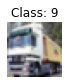

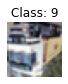

In [14]:
augmentation = transforms.RandomChoice([
    transforms.RandomHorizontalFlip(p=1.),
    transforms.RandomVerticalFlip(p=1.),
    transforms.RandomRotation(180),
])

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])

### 여러개의 데이터 증강 사용
- `Compose` 함수를 이용하면 지정한 데이터 증강 방법들을 순차적으로 진행하도록 할 수 있습니다.
- 보통 한가지의 증강 방식만을 사용하기 보다는 다양한 증강 방식을 동시에 사용하므로 매우 유용한 함수입니다.

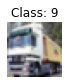

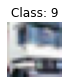

In [16]:
augmentation = transforms.Compose([ # Compose 함수를 이용하면, 여러개의 Augmentation 을 순차적으로 하도록 할 수 있다.
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomCrop(20)])

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])

### 무작위 순서 바꾸기
- 이 함수는 `Compose` 에서 조금 더 랜덤성을 부여해 줄 수 있는데, 설정한 데이터 증강 방법들을 순차적으로 하지 않고, 그 순서를 무작위로 바꿔서 진행합니다.


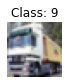

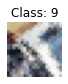

In [15]:
augmentation = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.RandomCrop((20, 20)),
])
# Compose는 쌓은 순서대로 진행하는데, RandomOrder은 쌓은 것을 랜덤하게 해준다.

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])

### 무작위 gray scale 변환
- 무작위으로 이미지의 색상을 grayscale로 변환해줍니다.


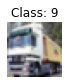

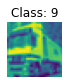

In [17]:
augmentation = transforms.Grayscale()

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])

### 자동 데이터 증강
- 무작위로 policy 에 맞는 데이터증강 방법을 사용하게 됩니다

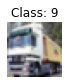

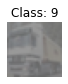

In [18]:
augmentation = transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET)

train_dataset_no_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=None,
                                             download=False)

train_dataset_aug = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=augmentation,
                                             download=False)

visualize_img(train_dataset_no_aug[1][0], train_dataset_no_aug[1][1])
visualize_img(train_dataset_aug[1][0], train_dataset_aug[1][1])


## 2-2. Augmentation 없이 학습

- 간단하게 `torchvision` 패키지를 이용해서 augmentation 을 하는 방법을 알아보았습니다.
- augmentation 이 있을 때, 없을 때 성능 차이를 확인해보기 위해서 augmentation 이 없을 때와 있을 때 모델 학습을 진행해보겠습니다.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10 # 시간 관계상 작은 epoch 로 모델 학습
learning_rate = 0.001

/home/jjam/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [20]:
transform = transforms.Compose([
    #추가할려면 이 부분에 쌓아주면 된다.# 여기에 위에서 알아본 데이터 증강 방법들을 넣어주면 됨.
    transforms.ToTensor()]) # CNN 모델을 학습하려면 jpg 형태에서 tensor 형태로 변환이 되어야 하기 때문에, ToTensor() transformation 을 항상 마지막에 넣어주어야 함.

In [21]:
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=500,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)

Files already downloaded and verified


In [22]:
class DevelopConv(nn.Module):
    def __init__(self):
        super(DevelopConv, self).__init__()

        self.conv = torchvision.models.resnet18(pretrained=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


model = DevelopConv().to(device)

/home/jjam/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jjam/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# GPU필수

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

## 2-3. (실습) Augmentation 해서 학습
- 위에서 배운 데이터 증강 방법들에 대한 함수들의 인자를 바꿔가며 코드를 실행해보세요.
- 그리고 그것들을 활용해서 모델 학습을 진행해보세요.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
learning_rate = 0.001

In [ ]:
transform = transforms.Compose([
    ### 이 부분을 채워주세요.
    transforms.Pad(2, padding_mode='reflect'),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTnsor(),
    transforms.Normalize([])
    ######
    transforms.ToTensor()])


test_transform = transforms.Compose([
    transforms.ToTensor()])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=test_transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=500,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)

In [ ]:
class DevelopConv(nn.Module):
    def __init__(self):
        super(DevelopConv, self).__init__()

        ### 이 부분을 채워주세요.

        ###

    def forward(self, x):
        ### 이 부분을 채워주세요.

        ###
        return x

    def embed(self, x):
        return self.conv(x)

model = DevelopConv().to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        ### 이 부분을 채워주세요

        ###

        ### 이 부분을 채워주세요

        ###

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

## 2-4. Advanced Augmentation 방법들 소개

- 아까까지는 가장 기본이 되는 데이터 증강 방법들을 알아보았습니다.
- 이번에는 좀 더 발전된 방식의 데이터 증강 방법들을 알아보겠습니다.
- 바로 Mixup / Cutout / Cutmix 입니다.
- 아래 그림에서 각 데이터 증강 방법론을 쉽게 이해해볼 수 있습니다.

<!-- <img src='https://miro.medium.com/v2/resize:fit:720/format:webp/0*PbO292lxR56d2dQ0.jpeg' width="600" height="auto"> -->

<img src='https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2605845%2Ff29492171d83dfa6b6fcae2af414fcf8%2FCutmix_exmaple.png?generation=1579343294489994&alt=media' width="600" height="auto">


좀 더 자세히 알아보면

1. **Mixup**
- mixup 은 학습데이터 중 무작위로 두개의 샘플을 뽑아서 말그대로 mix 하여 새로운 학습 샘플을 만들어 내는 방식입니다.
- 아래 그림을 보시면 고양이와 강아지 사진이 있는데요. 이 두 사진을 7:3 비율로 섞어본다면 어떻게 될까요?
- 고양이가 보이는데 흐릿하게 강아지의 모습도 보이는 사진이 만들어지게 됩니다. 그렇다면 이 사진은 70% 정도는 고양이인데, 30% 정도는 강아지인 샘플이 됩니다.
- 따라서 이 사진의 class label 은 [0.7, 0.3] 의 값을 가지게 됩니다.
- 다시 말해, 고양이 사진과 강아지 사진을 7:3 비율로 선형 보간 (linear interpolation), 그리고 각 label 값도 7:3 비율로 선형 보간 (linear interpolation) 하는 것을 의미합니다.

$$
\tilde{X} = X_1 \cdot \lambda + X_2 \cdot (1-\lambda)
$$

$$
\tilde{Y} = Y_1 \cdot \lambda + Y_2 \cdot (1-\lambda)
$$

<img src='https://crazyoscarchang.github.io/images/2020-09-27-revisiting-mixup/classical_mixup.png' width="600" height="auto">

- 사람이 보기에는 조금 어색한 사진이 만들어지지만, 이러한 데이터 증강 방식이 더욱 강건한 모델 학습을 가능하게 한다는 연구결과가 있어서 널리 사용되는 방법입니다.
    - [관련 문헌](https://arxiv.org/abs/1710.09412)



### (실습) Mixup 을 수행한 후, visualize 해보기

Files already downloaded and verified


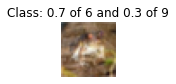

In [33]:
# training dataset 불러오기
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
# 0번째 index 의 example 와 1번째 index 의 example 을 mixup 해볼 것이다.
img1, label1 = train_dataset[0]
img2, label2 = train_dataset[1]

# lambda=0.7 인 mixup 을 수행하는 코드를 작성해보세요.
# 그리고 mixup 된 이미지를 시각화해보세요. Hint: plt.imshow() 함수를 이용해보세요. plt.imshow() 함수는 tensor 를 넣으면 image 로 보여주는 함수입니다.

### 이부분에 작성해주세요
visualize_img_tensor(img1 * 0.7 + img2 *0.3, f'0.7 of {label1} and 0.3 of {label2}')
###

2. **Cutout**
- Cutout 은 아래 예시를 보면 단번에 알 수 있듯이, 원본 사진에서 무작위로 상자를 만들고 그 부분을 없애버리는 방법입니다.
    - 즉, 사진의 object 일부분을 가려놓고서 그 object 맞추게끔 모델이 학습하게 되는 것입니다.
- Object 의 일부분이 가려져 있기 때문에, 가려지지 않은 부분만을 보고서 그 object 를 맞추어야 합니다. 따라서 해당 object 가 가지는 다양한 시각적 특징을 capture 할 수 있을 것입니다.

<img src='https://raw.githubusercontent.com/xkumiyu/numpy-data-augmentation/master/data/output/cutout.jpg' width="600" height="auto">

- 이 데이터 증강 방식이 효과적인 이유를 직관적으로 생각해보겠습니다.
- 예를 들어, 강아지의 반절만 나오는 사진을 보고 모델이 이 사진이 강아지의 사진인지 맞춰야 하는 상황을 가정해보겠습니다.
- 만약, 온 몸통이 모두 정확하게 나오는 강아지 사진만을 가지고 학습한 모델이라면, 이런 상황에 어려움을 겪을 수 있을 것입니다.
- 하지만 Cutout 을 통해 증강된 데이터셋으로 학습된 모델이라면, 이러한 상황에 잘 적응할 수 있으리라 기대할 수 있습니다.
- Cutout 데이터 증강 방법 또한 다양한 문헌에서 효과성이 입증된 방법으로, 널리 사용되는 데이터 증강 방법입니다.

- [관련 문헌1](https://arxiv.org/abs/1708.04552) [관련 문헌2](https://arxiv.org/abs/1708.04896)

- Cutout 의 구현은 `torchvision.transforms.RandomErasing` 함수를 통해 구현할 수 있으니 참고해주세요.

3. **Cutmix**
- Cutmix 는 위의 Mixup 과 Cutout 의 한계점을 개선한 방법론입니다.
    - 여담으로 이 방법은 네이버에서 한국인 연구자들이 개발해낸 방법론입니다.
- Mixup 방법은 효과적이었지만, 두개의 다른 이미지를 선형 보간 (linear interpolation) 하는 과정에서 이미지가 부자연스럽게 생성이 되어 시각적 정보가 왜곡이 되는 문제가 있었습니다.
- Cutout 방법도 효과적이었지만, 무작위로 사진의 일부분을 지워버리기 때문에 정보의 손실이 크다는 문제가 있었습니다.

- 이 두가지 문제를 해결하면서, 두가지 방법들의 장점을 그대로 가져가기 위해서, Cutmix 라는 방법이 제안되었습니다.

![그림 1](Cutmix.png)


- 정말 간단하게도 다음과 같은 방식으로 실행됩니다.
    1. 두개의 샘플을 무작위로 고른다
    2. 한 샘플에서 무작위로 박스를 생성하여 crop 하고 다른 샘플에 cropped image 를 삽입한다.

- 이렇게 함으로써, mixup 에서의 시각적 정보 왜곡 문제와 cutout 에서의 시각적 정보 손실 문제를 해결하여, 더욱 강건한 모델을 만들 수 있습니다.

- [관련 문헌](https://arxiv.org/abs/1905.04899)

## 3. Ensemble
- Ensemble 은 CNN 모델 뿐만 아니라 Machine Learning 모델 전반에서 성능을 끌어올릴 수 있는 아주 일반적인 technique 입니다.

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-10-14-30-00.png' width="400" height="auto">


- 간단히 널리 쓰이는 방법은 다음과 같습니다
    1. 서로 다른 방식으로 모델을 여러개 학습한다.
    2. 각 모델에서 나온 예측 값을 합산하여 최종 예측 값을 생성한다.
- 이때, 서로 다른 방식이란 매우 다양하게 적용될 수 있습니다.
    - 데이터 전처리를 다르게 한 모델들
    - 데이터 증강 방식을 다르게 한 모델들
    - 아키텍처가 다른 모델들 (e.g., VGGNet, ResNet, ViT) 등등
    - 그 외 다양한 방법들. 일반적으로 서로 성능이 비슷한데 완전히 다른 패턴을 지닌 모델들의 예측 값을 합칠 때 더 효과적입니다.
        - 예를 들어, decision-tree 기반의 모델과 linear regression 기반의 모델의 ensemble 이런 식으로.
- 그리고, 예측 값을 합산하는 방식도 다양하게 적용될 수 있습니다
    - Simple averaging
    - Weighted averaging
    - Stacking
    - Blending 등등

- 이 방법이 잘 되는 이유는 매우 직관적입니다. M1 가 잘하고 M2 는 잘못하는 상황이 있는 반면, M1 은 못하고 M2  는 잘하는 상황이 있기 마련입니다.
- 이럴 때, 둘의 힘을 합치면 각 모델이 잘 하지 못 할 때 서로 도와줄 수 있기 때문입니다.
- 마치 무인도에 갇혔을 때, 힘이 좋은 사람들끼리만 같이 있을 때보다
    - 힘이 좋은 사람
    - 머리가 좋은 사람
    - 요리를 잘하는 사람
    - 멘탈이 강한 사람 등등 다양한 특성을 지닌 사람들이 함께 있을 때 더 생존할 확률이 높을 것이라는 사례와 유사한 것 같습니다.

Ensemble 방법은 각종 경진대회들에서도 매우 널리 쓰이고 효과성이 입증된 방법이므로 알아 두시면 도움이 될 것입니다.


## 4. TTA (Test Time Augmentation) (실습)

- TTA 는 말그대로 test time augmentation 으로 학습 과정에는 전혀 관여하지 않고, 오직 *test time* 때만 간단히 수행하여 성능을 올릴 수 있는 방법입니다.

- 아래 그림을 보시면 매우 직관적으로 이해하실 수 있습니다.
- 기존에는 학습된 모델에다가 우리가 예측해야하는 이미지를 바로 입력하여 예측 값을 출력했었습니다.
- TTA 는 그러지 말고 원본 이미지에 약간씩의 데이터 증강을 하여 변형된 이미지를 얻은 후에, 각각의 이미지에서 얻은 예측 값들을 활용해서 최종 예측 값을 내자는 아이디어입니다.

<!-- <img src='https://stepup.ai/content/images/2020/08/test_time_augmentation_concept.png' width="600" height="auto"> -->

<img src='https://www.researchgate.net/publication/364221558/figure/fig4/AS:11431281179231989@1691161982457/Test-time-augmentation-TTA-is-used-to-improve-the-model-performance-Predictions-are.png' width="700" height="auto">



- 약간 ensemble 과 유사한 느낌으로 더 강건한 예측을 해낼 수가 있습니다.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
learning_rate = 0.001

In [ ]:
tta = transforms.Compose([
    transforms.ToTensor()])

tta1 = transforms.Compose([
    ### 이 부분을 작성해보세요
    
    ###
    transforms.ToTensor()])

In [ ]:
test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=tta) ###

test_dataset_tta1 = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=tta1) ###

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, ###
                                          batch_size=100,
                                          shuffle=False)
test_loader_tta1 = torch.utils.data.DataLoader(dataset=test_dataset_tta1, ###
                                          batch_size=100,
                                          shuffle=False)

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels), (images1, labels1) in zip(test_loader, test_loader_tta1):
        images = images.to(device)
        images1 = images1.to(device)
        labels = labels.to(device)
        ### 이 부분을 채워보세요 두개 모델의 평균값

        ###
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

### ResNet 모델과 VGG 모델을 ensemble 해보기 (실습)

먼저 ResNet 모델 먼저 학습

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
learning_rate = 0.001

In [ ]:
transform = transforms.Compose([
    ### 이 부분을 채워주세요.

    ######
])
test_transform = transforms.Compose([
    ### 이 부분을 채워주세요.

    ######
])


In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=test_transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=500,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)

In [ ]:
class ResNetConv(nn.Module):
    def __init__(self):
        super(ResNetConv, self).__init__()

        ### 이 부분을 채워주세요.

        ###

    def forward(self, x):
        ### 이 부분을 채워주세요.

        ###
        return x

    def embed(self, x):
        return self.conv(x)

resnetmodel = ResNetConv().to(device) # 객체 이름 resnetmodel

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnetmodel.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward Step
        ### 이부분을 채워주세요

        ###

        # Backward and optimize
        ### 이부분을 채워주세요

        ###

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


그 다음 VGG 모델 학습

In [ ]:
class VGGConv(nn.Module):
    def __init__(self):
        super(VGGConv, self).__init__()

        ### 이 부분을 채워주세요.

        ###

    def forward(self, x):
        ### 이 부분을 채워주세요.

        ###
        return x

    def embed(self, x):
        return self.conv(x)

vggmodel = VGGConv().to(device) # 객체 이름 vggmodel

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vggmodel.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        ### 이 부분을 채워주세요.

        ###

        # Backward and optimize
        ### 이 부분을 채워주세요.

        ###


        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

ResNet 모델 Test

In [ ]:
# Test the model
resnetmodel.eval()
vggmodel.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs =resnetmodel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the ResNet model on the test images: {} %'.format(100 * correct / total))

VGG 모델 Test

In [ ]:
# Test the model
vggmodel.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs =vggmodel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the VGG model on the test images: {} %'.format(100 * correct / total))

Ensemble Test
- simple averaging 으로 ensemble 을 구현해보세요!

In [ ]:
# Test the model
resnetmodel.eval()
vggmodel.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ### 이 부분을 채워주세요.

        ###
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the Ensemble model on the test images: {} %'.format(100 * correct / total))

## 5. Pseudo Labeling
- Pseudo labeling 은 training data 에 unlabeled data 가 있거나, test data 에 적용할 수 있는 방법입니다.
- 아래 그림을 보시면, 먼저 labeled data 가 주어져 있습니다. 저희는 이 labeled data 를 이용해서 model 을 학습할 수가 있습니다.
- 저희 model 이 잘 학습이 되었다면, 어떤 data 를 넣으면 그에 대한 예측 값을 출력할 것입니다.
- model 은 두가지의 예측 값을 출력할 수 있습니다.
    - 아주 자신있는 예측 값 (class 예측 확률이 매우 높은 경우)
    - 자신 없는 예측 값 (class 예측 확률이 낮은 경우)

- 이때, 우리에게 unlabeled data 가 주어져 있는데, label 정보가 없어서 쓰고 있지 못했다면, 우리가 학습한 model 로 가짜 label (pseudo label) 을 부여해줄 수 있습니다.

- 즉, 우리의 model 이 unlabeled data 에 대해 아주 자신있게 예측을 했다면, 그 선택을 믿고 가짜 label 을 해주는 것입니다.

- 그렇게 되면, 우리는 원래 갖고 있던 labeled data 에 가짜로 label 을 부여한 pseudo-labeled data 를 합쳐서 새로운 labeled dataset 를 형성할 수 있습니다.

- 그 dataset 으로 model 을 재학습하면 됩니다.

-
<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2017/09/20185606/pseudo-labeling.png' width="500" height="auto">

- pseudo labeling 은 test data 에도 적용이 가능합니다.
    - training time 에 test data 의 값에 접근이 가능한 상황에서만
- 주어진 training data (labeled data) 를 가지고 model 을 학습합니다.
- test data 의 예측값을 구합니다. 그리고 아주 자신있는 예측을 한 data 들에게 pseudo label 을 부여합니다.

- 그리고 pseudo-labeled data 와 training data 와 합치고 모델 재학습을 진행합니다.

- 이러한 pseudo labeling 방법은 labeled data 가 적을 때, 효과적으로 사용할 수가 있습니다.

- 하지만, 단점이 있는데, model 을 계속해서 재학습 해주어야 한다는 것입니다. 이는 상당히 많은 cost 를 유발합니다.

- 그래서 self-training 이라는 방식을 적용하게 되면 이러한 문제를 조금 해결할 수 있습니다.

- self-training 은 위의 pseudo labeling 과정을 학습 epoch 마다 진행하는 것입니다.

    - 특정 epoch 때, unlabeled data 에 대한 예측 값을 구합니다.
    - 아주 자신있는 예측을 한 data 들에게 pseudo-label 을 부여하고, labeled data 와 합쳐줍니다.
    - 그리고 다음 epoch 의 model 학습에 사용합니다.
    - 이 과정을 매 epoch 마다 반복합니다.




## 6. Label Smoothing
- 보통 이미지 데이터셋을 수집한다고 하면 어떻게 하게 될까요?
- 어떤 방식이든 이미지를 모은 후에, 사람이 직접 또는 자동화 기계를 이용해서 그 이미지의 labeling 을 진행하게 됩니다.
- 이때, 필연적으로 잘못 label 된 sample 이 생기게 됩니다.
    - 사람의 실수에 의해서든, 자동화 기계의 오류에 의해서든.
- 이를 칭해, noisy label 이라고 부릅니다.

- noisy label 을 가진 data 로 모델을 학습하게 되면 어떻게 될까요?
- model 이 매우 헷갈리게 되면서, 성능이 떨어지게 되는 결과를 낳게 됩니다.

- 이러한 noisy label 문제는 다양한 도메인과 태스크에 존재하여 CNN model 의 성능 향상을 방해하는 요소가 됩니다.

<img src='https://imerit.net/wp-content/uploads/2021/03/StrucGraph-org-1024x755.png'>



- 이를 방지해줄 수 있는 방법이 label smoothing 입니다.
- 아래 그림을 보시겠습니다. 기존에는 정답 값이, one-hot encoding 을 통해, 3번 class 에 속하면 3번 class 에 1값이 부여되었습니다.
- 즉, cross entropy loss 를 통해 model 을 학습하면, 3번 class 에 대한 예측 확률이 최대한 1에 가깝게 되도록 모델이 학습되는 것입니다.

- 하지만, 어떤 data 든지 간에 noisy label 일 가능성을 배제할 수 없습니다.

- 그래서 class label 값을 1에서 약간 낮춘 0.91 이라는 값을 주고 0.9는 나머지 class 에 균등하게 분배합니다.

- 즉, "이 data 는 class 3 이긴한데, 다른 class 일수도 있어~" 라는 약간의 여지를 남겨줌으로써 모델이 "이 모델은 무조건 class 3이야!" 라고 학습되기 보다는 "class 3일 수도 있는데 아닐 수도 있겠다" 라고 해서 덜 자신있는 예측을 하게끔 만들어 줍니다.

<img src='https://miro.medium.com/v2/resize:fit:1400/1*BDXCF-C9azGzr-OFzBFlEw.png' width="600" height="auto">

- 이렇게 해서, model 이 data 에 존재하는 noisy label 에 너무 민감하게 반응하지 않게끔 regularization 을 해주어, 성능 향상을 꾀할 수 있습니다.

[관련 문헌1](https://arxiv.org/abs/1906.02629) [관련 문헌2](https://openaccess.thecvf.com/content_CVPR_2020/papers/Yuan_Revisiting_Knowledge_Distillation_via_Label_Smoothing_Regularization_CVPR_2020_paper.pdf)

이외에도 성능을 올릴 수 있는 다양한 방법들이 있는데 다음 논문이 이를 잘 서술하고 있습니다. 참고하시면 도움이 될 것입니다.

[관련 문헌](https://openaccess.thecvf.com/content_CVPR_2019/papers/He_Bag_of_Tricks_for_Image_Classification_with_Convolutional_Neural_Networks_CVPR_2019_paper.pdf)

- 지금까지는 성능을 올리기 위한 기술적인 테크닉이었습니다.
- 지금부터는 현재 우리 모델의 상태를 점검해볼 수 있는 다양한 정성분석 방법들을 소개드리겠습니다

## 7. t-SNE Visualization
- t-SNE는 주로 고차원의 복잡한 데이터를 2차원으로 축소하여 시각화하는 데 사용되며, 이 과정에서 비슷한 특성을 지니는 데이터끼리 가까이에 위치하게 되기 때문에 현재 우리의 model 이 옳은 방향으로 잘 학습되었는지를 파악하는 척도가 됩니다.


In [ ]:
embeddings_list, labels_list = [], []

for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    embedding = model.embed(images)
    embeddings_list.append(embedding.detach().cpu().numpy())
    labels_list.append(labels.detach().cpu().numpy())

In [ ]:
embedding = np.concatenate(embeddings_list, axis=0)
label = np.concatenate(labels_list)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(embedding[:2000])

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame()
df["y"] = label[:2000]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="CIFAR T-SNE projection")

## 8. Error Analysis
- Error Analysis 는 현재 우리 모델이 어떤 부분에 취약한지 파악할 수 있는 매우 중요한 분석 방법입니다.
- Error Analysis 는 말 그대로 학습 완료된 우리 모델이 어떤 example 들을 주로 틀리고, 어떤 example 들은 쉽게 맞추는지 확인하는 분석방법입니다. 일종의 오답노트라고 생각하시면 이해가 편할 것 같습니다.

<img src='https://miro.medium.com/v2/resize:fit:1400/1*edgAghV0PGZ8BydSuGdXQg.png' width="600" height="auto">




- test example 은 모델 개발시에 공개되지 않으니, validation example 들을 이용해서 맞은 sample 그리고 틀린 sample 을 쭉 나열한 후에 틀린 sample 들의 특징들을 정리해볼 수 있습니다.
- 위에서 소개드린 다양한 성능을 올리는 테크닉들도 좋지만, 우리 모델이 잘 하지 못하는 부분을 파악해서 그 부분을 직접적으로 해결하는 것 또한 성능을 올리는데 매우 중요한 요소입니다.
